In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
from  matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.ndimage

# draw the dark hole regions
from skimage.draw import draw

# PSD code
from scipy import signal
from scipy import interpolate
import h5py
import copy

#import poppy

# import personal code
import sys
sys.path.insert(0, '/home/jhen/XWCL/code/MagAOX/functions') # change this per computer
import psd_functions as psd
import datafiles as dfx

#import magaoxFunctions as mf

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
#print('This notebook is not stale yet!')

In [2]:
%%time
opt_parms = {'ca' : 80, # of the 80% CA given
             'ovs': 4096,
             'surf_units': u.micron,
             'ring_width': 5,
             'diam_ca100': 25*u.mm,
             'label': '1in'} 

fm_list = [1, 2, 3, 4, 5, 6, 7, 8]
#fm_list=[7,8]
ntot= len(fm_list)
fits_folder = 'zygo_data/flat_mirrors/fixed_fits/'

# build dust lists
fm = [] # objects list: [flat mirror with average dust masked].objects
flat_psd = np.zeros((ntot, opt_parms['ovs']*opt_parms['ovs']))
flat_var = np.zeros((ntot))

# This loop masks the dust per step for all the optics
for nf in range(0, ntot): # choose optic
    fm_num = fm_list[nf]
    
    # open the dust sets
    filename = fits_folder+'flat_{0}_ca{1}_n{2}_dustmask'.format(opt_parms['label'], opt_parms['ca'], fm_num)
    
    # calculate the PSD
    adp = psd.surfPSD(surf_name='fm{0}_alldust'.format(fm_num))
    adp.open_surf(fileloc=filename+'_surf.fits', surf_units=opt_parms['surf_units'])
    adp.open_mask(fileloc=filename+'_mask.fits')
    adp.calc_psd(oversamp = opt_parms['ovs'])
    #adp.write_psd_file(filename=filename+'_PSD.fits', psd_data=adp.psd_cal, single_precision=False)
    adp.calc_psd_radial(ring_width=opt_parms['ring_width'])
    print('PSD and radial profile for all dust masked in fm{0} complete.'.format(fm_num))
    
    # add objects to the lists
    fm.append(adp)
    # for the 1inch mirrors, because they are similar, you can use the calibrated PSD instead to average.
    flat_psd[nf] = adp.psd_cal.reshape(opt_parms['ovs']*opt_parms['ovs'])
    flat_var[nf] = adp.var.value
    
# calculate the average flat
psd_avg = np.mean(flat_psd, axis=0).reshape(opt_parms['ovs'], opt_parms['ovs'])*fm[0].psd_cal.unit
# calibrate the average PSD
var_avg = np.mean(flat_var)*fm[0].var.unit
#cal_psd_avg = norm_psd_avg*var_avg
#create the radial psd profile by making its own object
avg_psd = psd.surfPSD(surf_name='fm1inch_alldust_avg')
avg_psd.load_psd(psd_data=psd_avg, psd_type='cal', var=var_avg)
avg_psd.load_psd_parameters(oversamp=fm[0].oversamp,
                            diam_ca=fm[0].diam_ca,
                            npix_diam=fm[0].npix_diam,
                            wavelen=fm[0].wavelen)
avg_psd.calc_rms_set(kmid_ll=0.1/u.mm, khigh_ll=1/u.mm, pwr_opt=avg_psd.psd_cal)
avg_psd.write_psd_file(filename=fits_folder+'flat_{0}_ca{1}_avg_dustmask_PSD.fits'.format(opt_parms['label'], opt_parms['ca']),
                       psd_data = avg_psd.psd_cal,
                      single_precision=False)
avg_psd.calc_psd_radial(ring_width=opt_parms['ring_width'])
print('PSD and radial profile for all dust masked in averaged surface complete.')

PSD and radial profile for all dust masked in fm1 complete.
Bad data present: 193 nan pixels. Interpolating to fix.
PSD and radial profile for all dust masked in fm2 complete.
PSD and radial profile for all dust masked in fm3 complete.
Bad data present: 193 nan pixels. Interpolating to fix.
PSD and radial profile for all dust masked in fm4 complete.
PSD and radial profile for all dust masked in fm5 complete.
PSD and radial profile for all dust masked in fm6 complete.
PSD and radial profile for all dust masked in fm7 complete.
PSD and radial profile for all dust masked in fm8 complete.
PSD and radial profile for all dust masked in averaged surface complete.
CPU times: user 6min 25s, sys: 2min 12s, total: 8min 38s
Wall time: 8min 25s


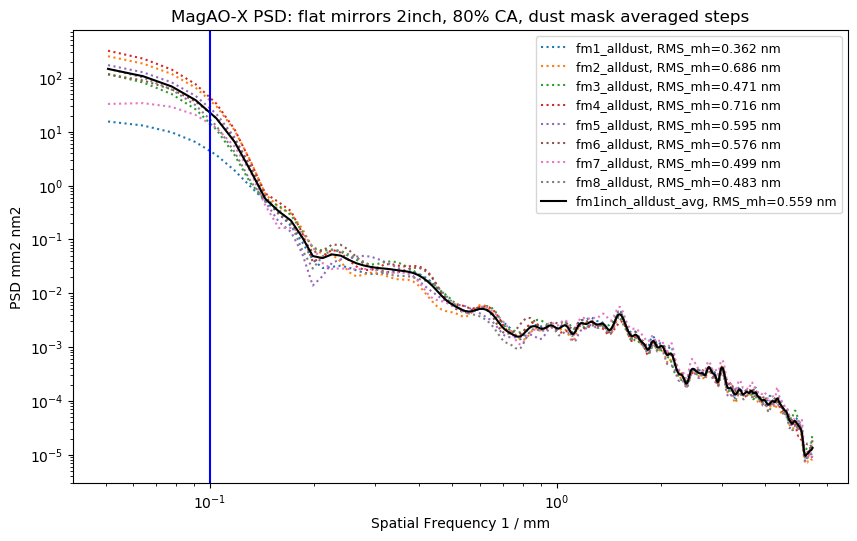

In [3]:
plt.figure(figsize=[10,6],dpi=100)
for obj in fm:
    plt.loglog(obj.k_radial.value, obj.psd_radial_cal.value, ':', label='{0}, RMS_mh={1:.3f}'.format(obj.surf_name, obj.rms_mh))
plt.loglog(avg_psd.k_radial.value, avg_psd.psd_radial_cal.value, 'k', label='{0}, RMS_mh={1:.3f}'.format(avg_psd.surf_name, avg_psd.rms_mh))
plt.xlabel('Spatial Frequency {0}'.format(fm[0].k_radial.unit))
plt.ylabel('PSD {0}'.format(fm[0].psd_radial_cal.unit))
plt.title('MagAO-X PSD: flat mirrors 2inch, {0}% CA, dust mask averaged steps'.format(opt_parms['ca']))
plt.legend(prop={'size':9})#,loc='center left', bbox_to_anchor=(1, 0.5))
plt.axvline(x=0.1, color='b')

It's doing that thing again where the average calibrated PSD looks worse than the actual data. I think the solution was to throw away the 2 bad data points (fm2, fm4)

In [5]:
nfms = []
nfnorm = []
nfvar = []
bad_optics=[2,4]
for nf in fm_list:
    if nf not in bad_optics:
        nfms.append(fm[nf-1])
        nfnorm.append(fm[nf-1].psd_norm.reshape(opt_parms['ovs']*opt_parms['ovs']))
        nfvar.append(fm[nf-1].var.value)
        
# calculate the average flat
new_norm_psd_avg = np.mean(nfnorm, axis=0).reshape(opt_parms['ovs'], opt_parms['ovs'])*fm[0].psd_norm.unit
# calibrate the average PSD
new_var_avg = np.mean(nfvar)*fm[0].var.unit
new_cal_psd_avg = new_norm_psd_avg*new_var_avg
#create the radial psd profile by making its own object
new_avg_psd = psd.surfPSD(surf_name='fm1inch_alldust_avg_n2n4remove')
new_avg_psd.load_psd(psd_data=new_norm_psd_avg, psd_type='norm', var=new_var_avg)
new_avg_psd.load_psd_parameters(oversamp=fm[0].oversamp,
                            diam_ca=fm[0].diam_ca,
                            npix_diam=fm[0].npix_diam,
                            wavelen=fm[0].wavelen)
new_avg_psd.calc_rms_set(kmid_ll=0.1/u.mm, khigh_ll=1/u.mm, pwr_opt=new_avg_psd.psd_cal)
#avg_psd.write_psd_file(filename=fits_folder+'flat_{0}_ca{1}_avg_dustmask_PSD.fits'.format(opt_parms['label'], opt_parms['ca']),
#                       psd_data = avg_psd.psd_cal,
#                      single_precision=False)
new_avg_psd.calc_psd_radial(ring_width=opt_parms['ring_width'])
print('PSD and radial profile for all dust masked in averaged surface complete (remove n2, n4)')

PSD and radial profile for all dust masked in averaged surface complete (remove n2, n4)


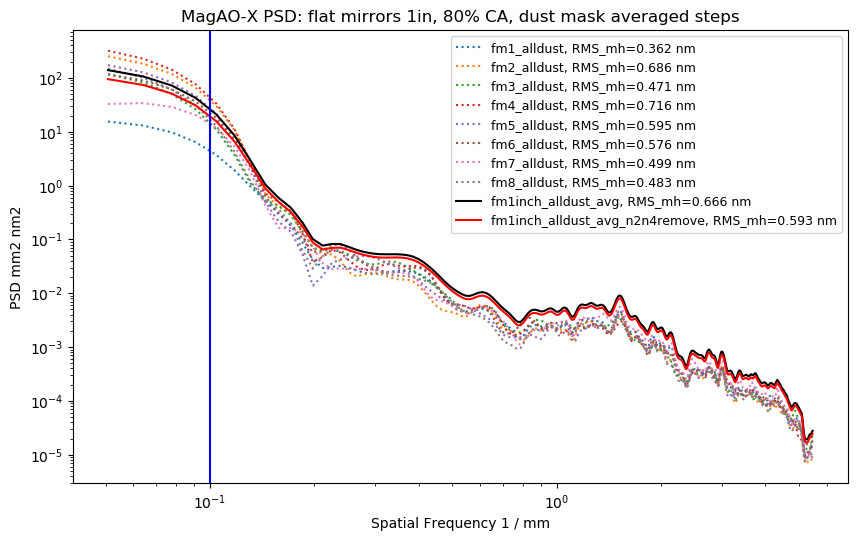

In [7]:
plt.figure(figsize=[10,6],dpi=100)
for obj in fm:
    plt.loglog(obj.k_radial.value, obj.psd_radial_cal.value, ':', label='{0}, RMS_mh={1:.3f}'.format(obj.surf_name, obj.rms_mh))
plt.loglog(avg_psd.k_radial.value, avg_psd.psd_radial_cal.value, 'k', label='{0}, RMS_mh={1:.3f}'.format(avg_psd.surf_name, avg_psd.rms_mh))
plt.loglog(new_avg_psd.k_radial.value, new_avg_psd.psd_radial_cal.value, 'r', label='{0}, RMS_mh={1:.3f}'.format(new_avg_psd.surf_name, new_avg_psd.rms_mh))
plt.xlabel('Spatial Frequency {0}'.format(fm[0].k_radial.unit))
plt.ylabel('PSD {0}'.format(fm[0].psd_radial_cal.unit))
plt.title('MagAO-X PSD: flat mirrors {0}, {1}% CA, dust mask averaged steps'.format(opt_parms['label'], opt_parms['ca']))
#plt.legend(prop={'size':9},loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend(prop={'size':9})
plt.axvline(x=0.1, color='b')

Same bad results. Let's inspect the normalized PSD radial plots.

In [8]:
%%time
norm_psd_radial = []
for obj in fm:
    obj.check_normpsd(psd_norm=obj.psd_norm)
    k_radial, psd_radial = obj.do_psd_radial(ring_width=opt_parms['ring_width'], psd_data=obj.psd_norm)
    print('{0} normalized PSD radial calculation completed.'.format(obj.surf_name))
    norm_psd_radial.append(psd_radial.value)

print()
# calculate the averaged normalized PSD radial value
avg_psd.check_normpsd(psd_norm=avg_psd.psd_norm)
avg_k_radial, avg_psd_radial_norm = avg_psd.do_psd_radial(ring_width=opt_parms['ring_width'], psd_data=avg_psd.psd_norm)
print('{0} normalized PSD radial calculation completed.\n'.format(avg_psd.surf_name))

# calculate the averaged normalized PSD radial value
new_avg_psd.check_normpsd(psd_norm=new_avg_psd.psd_norm)
new_avg_k_radial, new_avg_psd_radial_norm = new_avg_psd.do_psd_radial(ring_width=opt_parms['ring_width'], psd_data=new_avg_psd.psd_norm)
print('{0} normalized PSD radial calculation completed.'.format(new_avg_psd.surf_name))

PSD normalized: var=1.000
fm1_alldust normalized PSD radial calculation completed.
PSD normalized: var=1.000
fm2_alldust normalized PSD radial calculation completed.
PSD normalized: var=1.000
fm3_alldust normalized PSD radial calculation completed.
PSD normalized: var=1.000
fm4_alldust normalized PSD radial calculation completed.
PSD normalized: var=1.000
fm5_alldust normalized PSD radial calculation completed.
PSD normalized: var=1.000
fm6_alldust normalized PSD radial calculation completed.
PSD normalized: var=1.000
fm7_alldust normalized PSD radial calculation completed.
PSD normalized: var=1.000
fm8_alldust normalized PSD radial calculation completed.

PSD normalized: var=1.000
fm1inch_alldust_avg normalized PSD radial calculation completed.

PSD normalized: var=1.000
fm1inch_alldust_avg_n2n4remove normalized PSD radial calculation completed.
CPU times: user 5min 23s, sys: 2min 4s, total: 7min 28s
Wall time: 7min 28s


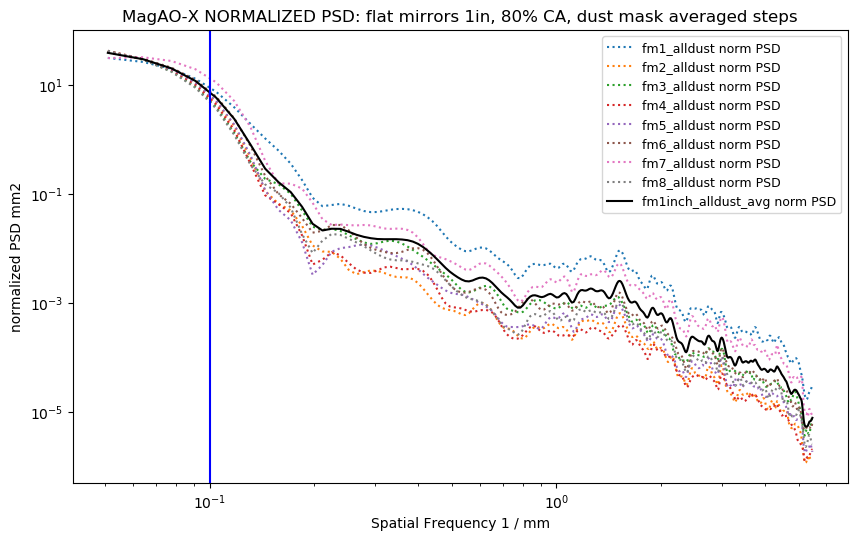

In [23]:
plt.figure(figsize=[10,6],dpi=100)
for nf in range(0, ntot): # choose optic
    plt.loglog(fm[nf].k_radial.value, norm_psd_radial[nf], ':', label='{0} norm PSD'.format(fm[nf].surf_name))
plt.loglog(avg_psd.k_radial.value, avg_psd_radial_norm.value, 'k', label='{0} norm PSD'.format(avg_psd.surf_name))
#plt.loglog(new_avg_psd.k_radial.value, new_avg_psd_radial_norm.value, 'r', label='{0} norm PSD'.format(new_avg_psd.surf_name))
plt.xlabel('Spatial Frequency {0}'.format(fm[0].k_radial.unit))
plt.ylabel('normalized PSD {0}'.format(avg_psd_radial_norm.unit))
plt.title('MagAO-X NORMALIZED PSD: flat mirrors {0}, {1}% CA, dust mask averaged steps'.format(opt_parms['label'], opt_parms['ca']))
#plt.legend(prop={'size':9},loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend(prop={'size':9})
plt.axvline(x=0.1, color='b')

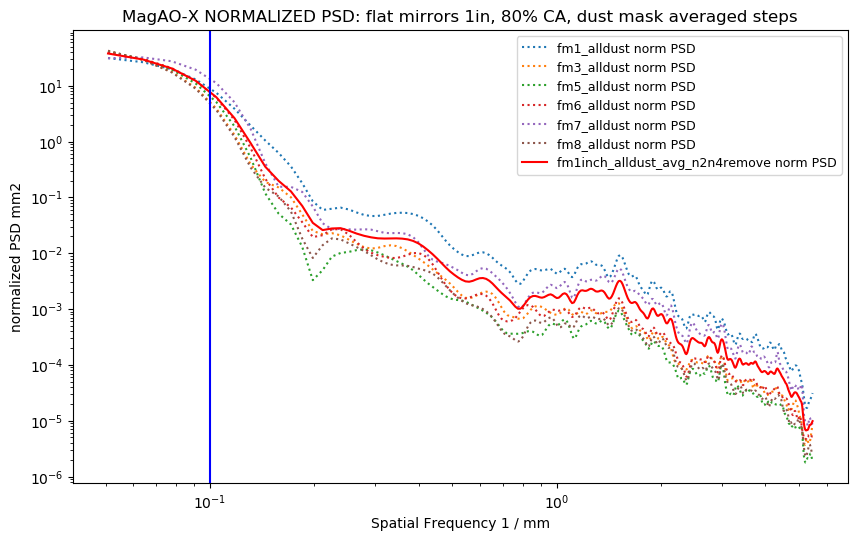

In [13]:
plt.figure(figsize=[10,6],dpi=100)
for nf in range(0, ntot): # choose optic
    if (nf+1) not in bad_optics:
        plt.loglog(fm[nf].k_radial.value, norm_psd_radial[nf], ':', label='{0} norm PSD'.format(fm[nf].surf_name))
#plt.loglog(avg_psd.k_radial.value, avg_psd_radial_norm.value, 'k', label='{0} norm PSD'.format(avg_psd.surf_name))
plt.loglog(new_avg_psd.k_radial.value, new_avg_psd_radial_norm.value, 'r', label='{0} norm PSD'.format(new_avg_psd.surf_name))
plt.xlabel('Spatial Frequency {0}'.format(fm[0].k_radial.unit))
plt.ylabel('normalized PSD {0}'.format(avg_psd_radial_norm.unit))
plt.title('MagAO-X NORMALIZED PSD: flat mirrors {0}, {1}% CA, dust mask averaged steps'.format(opt_parms['label'], opt_parms['ca']))
#plt.legend(prop={'size':9},loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend(prop={'size':9})
plt.axvline(x=0.1, color='b')

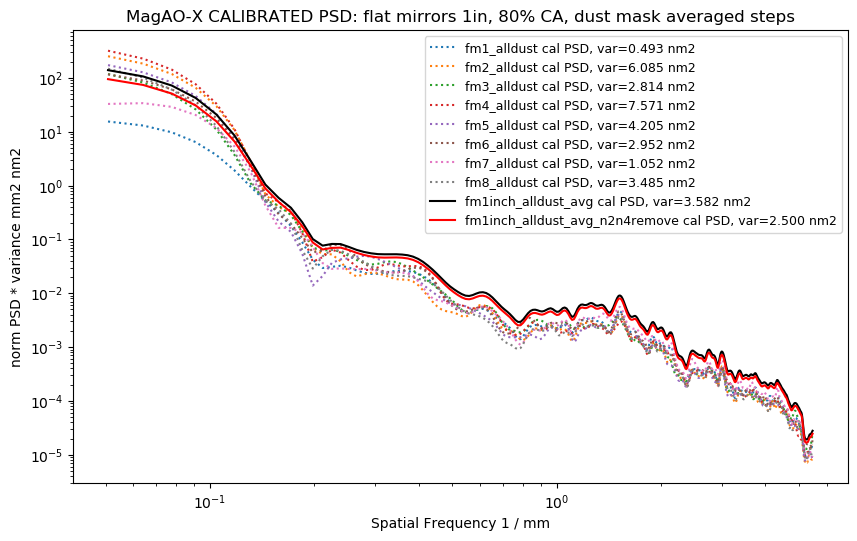

In [17]:
plt.figure(figsize=[10,6],dpi=100)
for nf in range(0, ntot):
    cal_psd = norm_psd_radial[nf]*fm[nf].psd_norm.unit*fm[nf].var
    plt.loglog(fm[nf].k_radial.value, cal_psd.value, ':', label='{0} cal PSD, var={1:.3f}'.format(fm[nf].surf_name, fm[nf].var))
cal_psd=avg_psd_radial_norm*var_avg
plt.loglog(avg_psd.k_radial.value, cal_psd.value, 'k', label='{0} cal PSD, var={1:.3f}'.format(avg_psd.surf_name, avg_psd.var))
cal_psd=new_avg_psd_radial_norm*new_var_avg
plt.loglog(new_avg_psd.k_radial.value, cal_psd.value, 'r', label='{0} cal PSD, var={1:.3f}'.format(new_avg_psd.surf_name, new_avg_psd.var))
plt.xlabel('Spatial Frequency {0}'.format(fm[0].k_radial.unit))
plt.ylabel('norm PSD * variance {0}'.format(cal_psd.unit))
plt.title('MagAO-X CALIBRATED PSD: flat mirrors {0}, {1}% CA, dust mask averaged steps'.format(opt_parms['label'], opt_parms['ca']))
#plt.legend(prop={'size':9},loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend(prop={'size':9})

In [31]:
for n in range(0, len(flat_var)):
    print('FM{0} variance: {1:.3f}'.format(n+1, fm[n].var))
print('\navg variance: {0:.3f} (all optics)'.format(var_avg))
print('avg variance: {0:.3f} (without FM2 and FM4)'.format(new_var_avg))

FM1 variance: 0.493 nm2
FM2 variance: 6.085 nm2
FM3 variance: 2.814 nm2
FM4 variance: 7.571 nm2
FM5 variance: 4.205 nm2
FM6 variance: 2.952 nm2
FM7 variance: 1.052 nm2
FM8 variance: 3.485 nm2

avg variance: 3.582 nm2 (all optics)
avg variance: 2.500 nm2 (without FM2 and FM4)


In [27]:
for n in range(0, len(flat_var)):
    print('FM{0} RMS_mh: {1:.3f}'.format(n+1, fm[n].rms_mh))

FM1 RMS_mh: 0.362 nm
FM2 RMS_mh: 0.686 nm
FM3 RMS_mh: 0.471 nm
FM4 RMS_mh: 0.716 nm
FM5 RMS_mh: 0.595 nm
FM6 RMS_mh: 0.576 nm
FM7 RMS_mh: 0.499 nm
FM8 RMS_mh: 0.483 nm
